# Phonology Mixed Sets -- Family vs. Fake Feature

In [1]:
from locator import *
from scipy.stats import ttest_ind,spearmanr
%matplotlib inline

### Sample Space
The following statistics are on a collection of 1500 feature-sets picked **at random** from the 23,000 feature sets of phonological features.
So all these sets are:
   
   - made of phonological feature (no restriction)
   
   - have a spectral index of 5 or more (by pca)
   
   - cover at least 200 languages

They were not selected for genetic separation!

To make the comparison fair, the bogus features were assigned to the languages in the top 2 families by matching proportions. That is to say, if for example a set covers 100 languages, of which the most common family is Indo-European with 20 languages and the second most common is Sino-Tibetan with 18 languages, then 20 random languages from those 38 were assigned the property "bogus-1" and the other 18 were assigned "bogus-2". The bogus silhouette is therefore the best silhoutte among the following computational parameters:

 - -1: language is represented in the original feature space, eucledian distance
 - 0: language is represented in the original feature space, manhatten distance
 - *i* in [1 -- number of categories]: language is represented by it's projection on *i* PCs,  eucledian distance

of course, the genetic silhouette is the same, only the labels are the real language families.

In [12]:
groups = pd.read_pickle('phon200-1500-rnd-samefams.pkl')

In [13]:
gstats = list()
for g in groups:
    g.determine_spectral_data()
    top2fams = g.families.most_common(2)
    gensilpca = g.best_silhouette('genetic')
    bogsilpca = g.best_silhouette('bogus')
    gstats.append({
        'spectral index' : g.quality_index,
        'genetic silhouette' : gensilpca[0],
        'genetic silhouette dims' : gensilpca[1],
        'bogus silhouette' : bogsilpca[0],
        'bogus silhouette dims' : bogsilpca[1],
        'family 1' : top2fams[0][1],
        'family 2' : top2fams[1][1]
    })
gstats = pd.DataFrame(gstats)

## The basic table

 - family 1: number of languages in the most common family and in bogus-1
 - family 2: number of languages in the second most common family and in bogus-2
 - spectral index: 1st eigenvalue * number of categories / sum(eigenvalues)
 - genetic/bogus silhouette dims: the number of PCs (including -1, and 0 as explained above) that gave the best silhoutte

In [14]:
gstats.describe()

,bogus silhouette,bogus silhouette dims,family 1,family 2,genetic silhouette,genetic silhouette dims,spectral index
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.017827,5.819333,29.131333,23.990667,0.221662,1.139333,6.600446
std,0.034797,8.008170,13.292751,10.218555,0.091800,0.830489,1.171338
min,-0.038222,-1.000000,15.000000,12.000000,0.000279,0.000000,5.001904
25%,-0.003271,1.000000,25.000000,20.000000,0.164080,1.000000,5.670709
50%,0.008127,2.000000,25.000000,21.000000,0.201870,1.000000,6.373357
75%,0.028262,7.000000,25.000000,21.000000,0.260271,1.000000,7.344923
max,0.263980,54.000000,56.000000,45.000000,0.585114,7.000000,10.770036


we can already see that he genetic silhouettes are heigher. 

But they are also uncorrelated with the bogus ones. Here are the tests to prove it:

### Correlation:

In [15]:
spearmanr(gstats['bogus silhouette'],gstats['genetic silhouette'])

SpearmanrResult(correlation=0.0075524857654902609, pvalue=0.770082614129175)

### Significance of Difference in Means (between genetic and bogus silhouette):

In [16]:
ttest_ind(gstats['bogus silhouette'],gstats['genetic silhouette'])

Ttest_indResult(statistic=-80.41346025710034, pvalue=0.0)

The bogus and genetic silhouettes also differ quite conspicously in the way they are distributed over the number of PCs giving the best silhouette. The genetic ones never need more than 7 PCs, while the bogus ones - although usually around 1 too - have some hits along the entire range more or less.

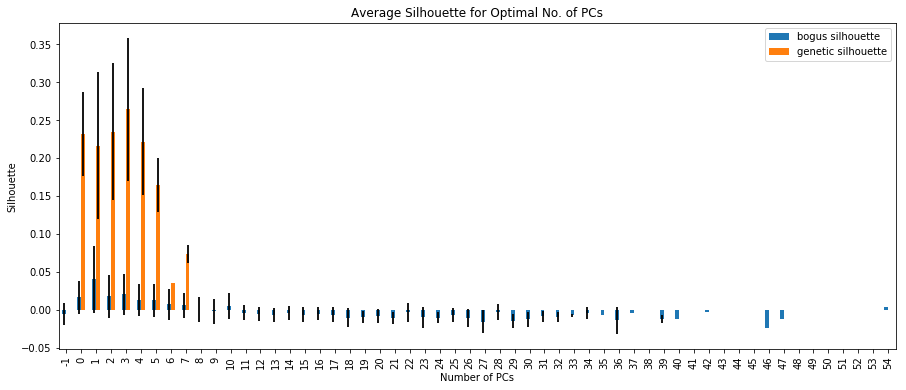

In [17]:
bog = gstats.groupby('bogus silhouette dims')['bogus silhouette']
gen = gstats.groupby('genetic silhouette dims')['genetic silhouette']

bmeans = bog.mean()
gmeans = gen.mean()

bstd = bog.std()
gstd = gen.std()

gmeans.sort_index(inplace=True)
gstd.sort_index(inplace=True)

gmeans.loc[-1] = 0
gstd.loc[-1] = 0

for i in range(gmeans.index.max()+1,bmeans.index.max()+1):
    gmeans.loc[i] = 0
    gstd.loc[i] = 0
    
means = pd.DataFrame([bmeans,gmeans])
stds = pd.DataFrame([bstd,gstd])

fig,ax = plt.subplots(figsize=(15,6))
ax.set_title("Average Silhouette for Optimal No. of PCs")
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Silhouette")
means.transpose().plot.bar(yerr=stds.transpose(),ax=ax)

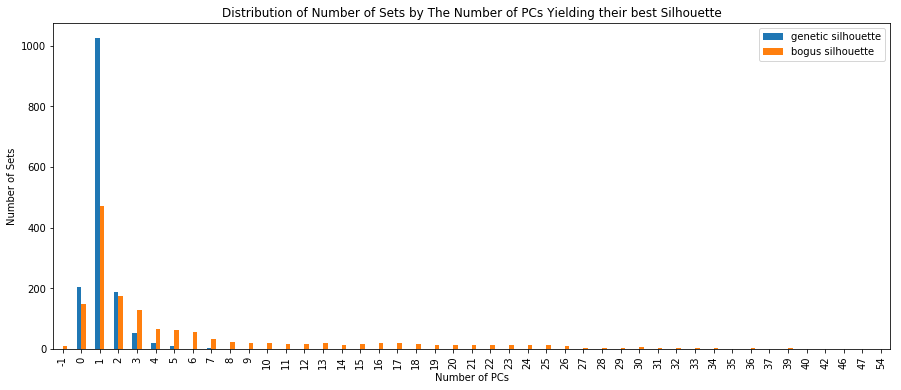

In [18]:
bcounts = bog.count()
gcounts = gen.count()
for i in range(gmeans.index.max()+1,bmeans.index.max()+1):
    gcounts.loc[i] = 0

fig,ax = plt.subplots(figsize=(15,6))
ax.set_ylabel("Number of Sets")
ax.set_xlabel("Number of PCs")
ax.set_title("Distribution of Number of Sets by The Number of PCs Yielding their best Silhouette")
counts = pd.DataFrame([gcounts,bcounts])
counts.transpose().plot.bar(ax=ax)

plt.show()

### This Graph Probably Says It All

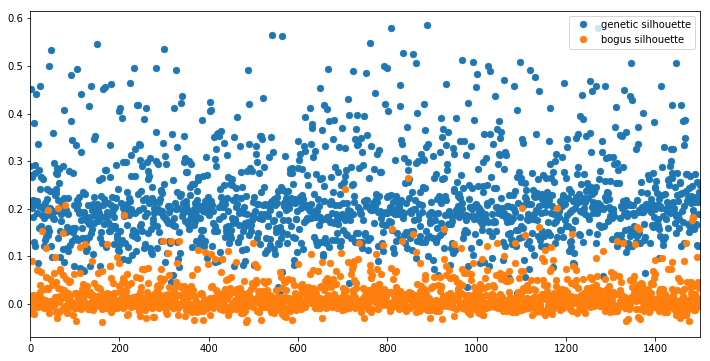

In [19]:
gstats[['genetic silhouette','bogus silhouette']].plot(style='o',figsize=(12,6))

## Some Examples from this Collection

### The set with the best bogus silhouette

In [20]:
bogmax = groups[gstats['bogus silhouette'].argmax()]

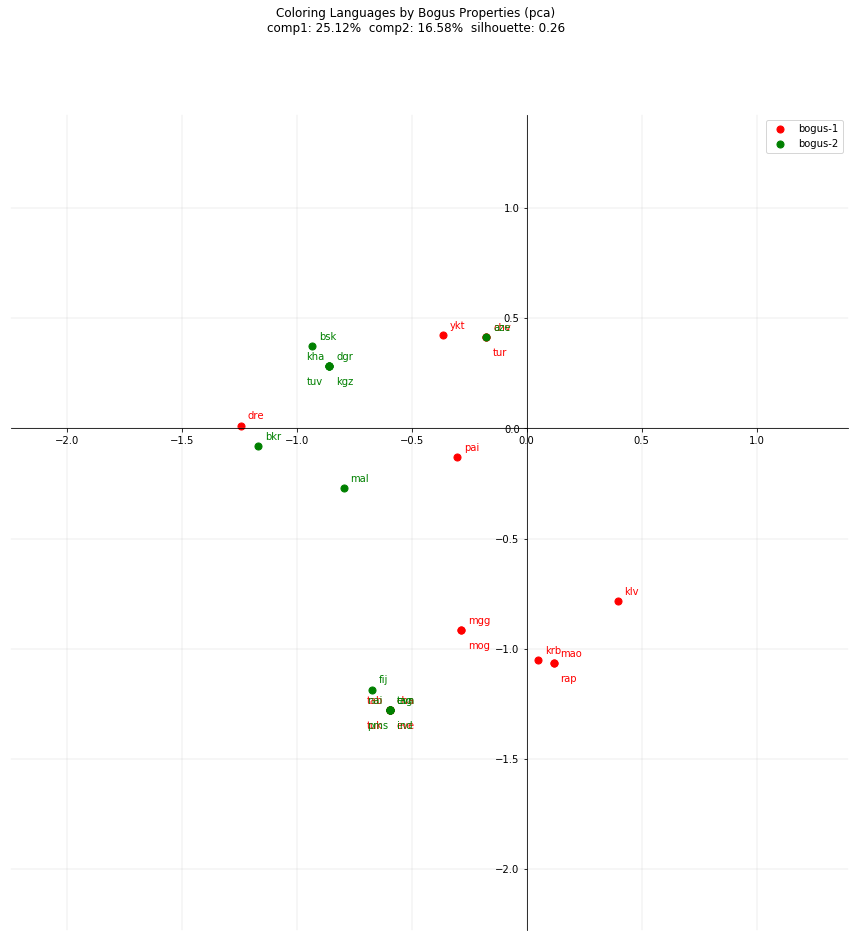

In [21]:
bogmax.plot_bogus()

### same set, painted by family 

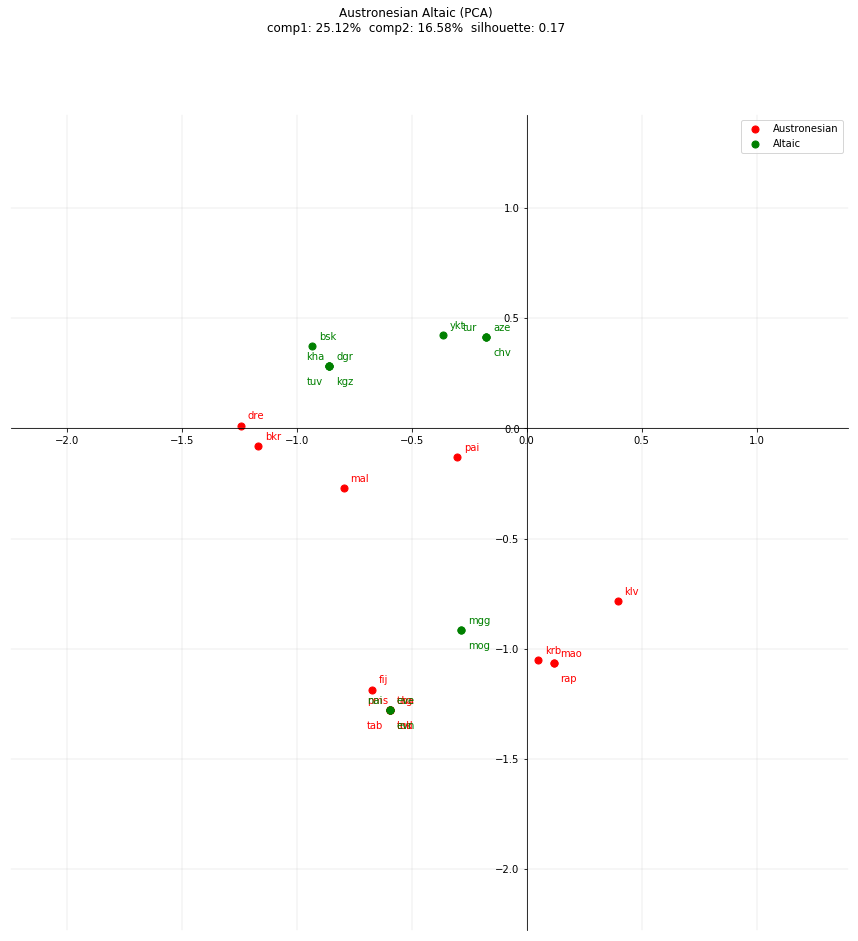

In [22]:
bogmax.plot_families()

### same set, showing all two-way separation of the top families

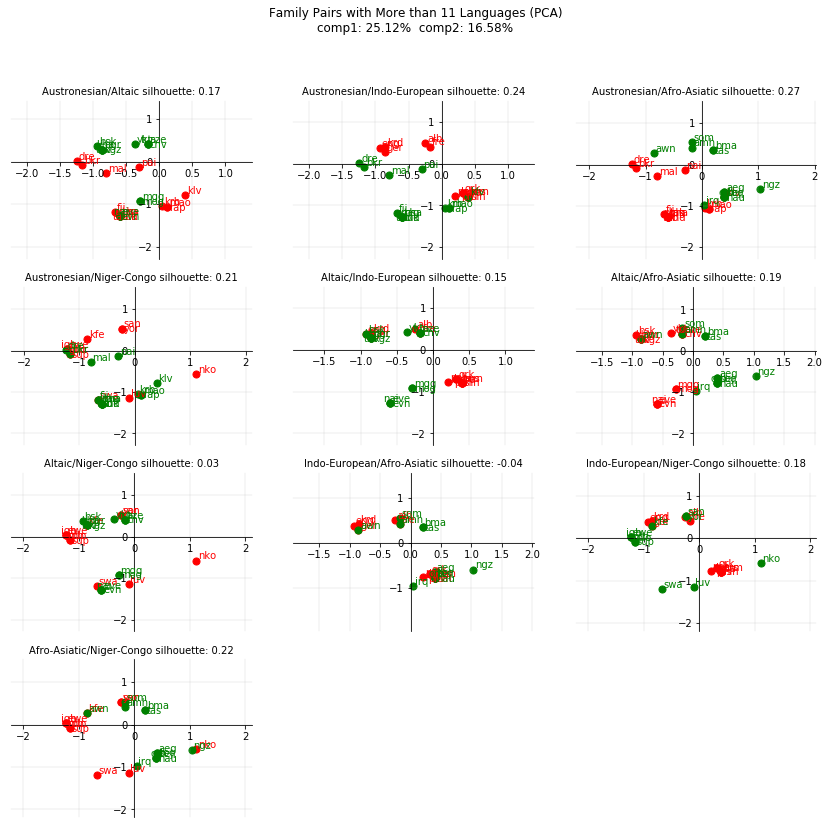

In [23]:
bogmax.plot_multifam()

### Of  Course, the set with the worst bogus silhouette doesn't look like anything

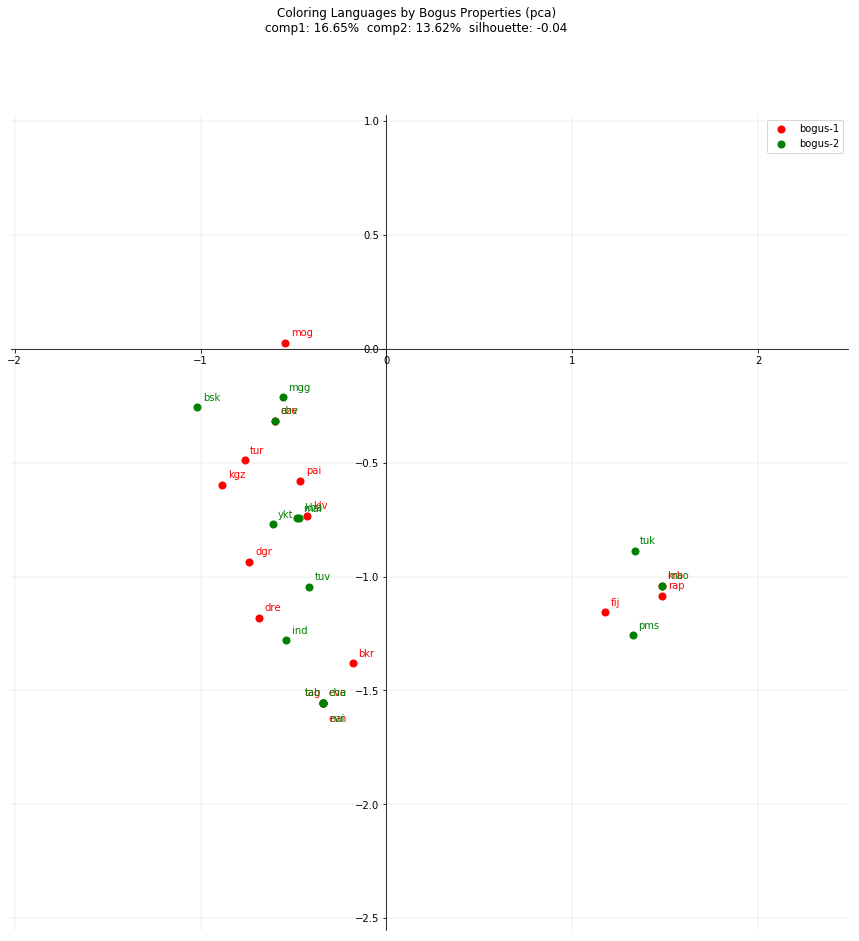

In [24]:
bogmin = groups[gstats['bogus silhouette'].argmin()]
bogmin.plot_bogus()

### same set (and same languages), colored by family

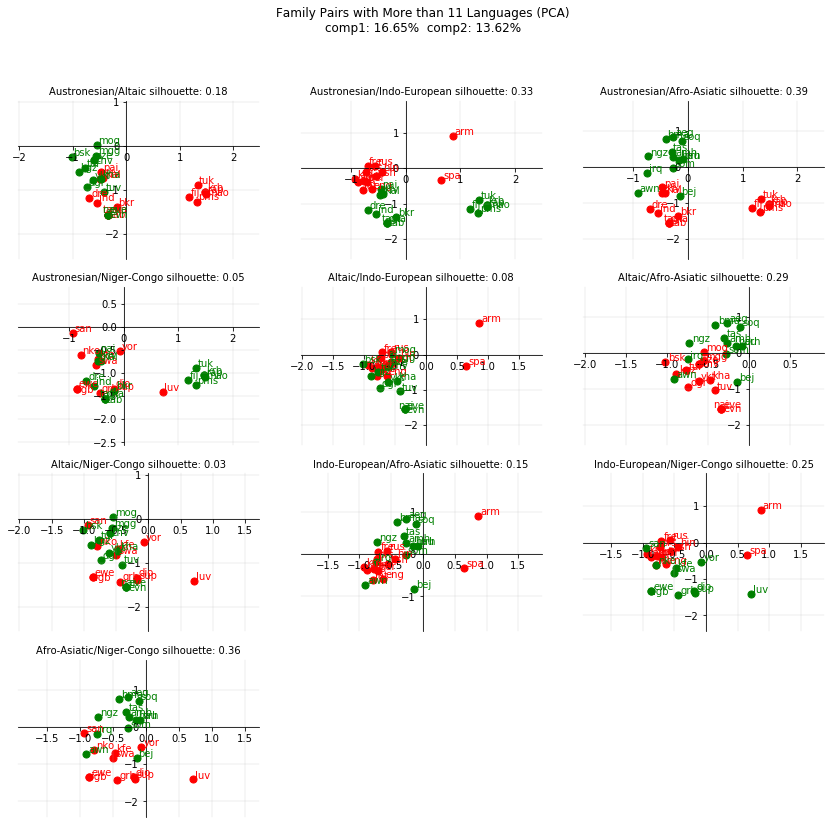

In [26]:
bogmin.plot_multifam()

### The set with the most languages in family 1

In [27]:
maxfams = groups[gstats['family 1'].argmax()]

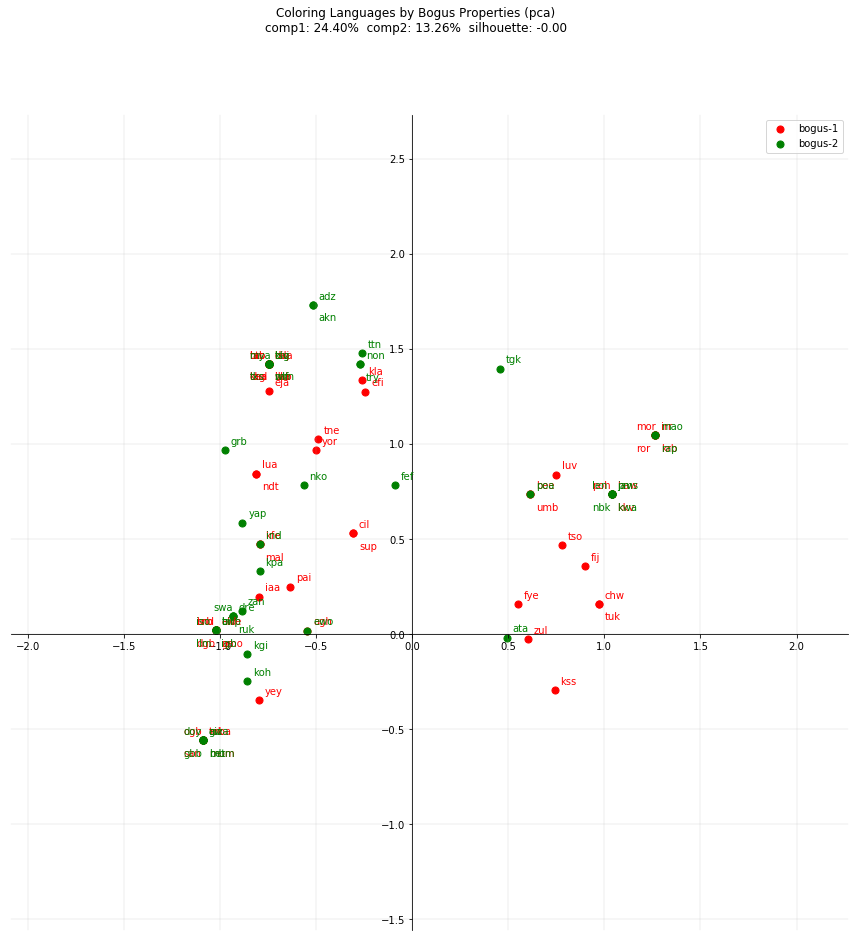

In [28]:
maxfams.plot_bogus()

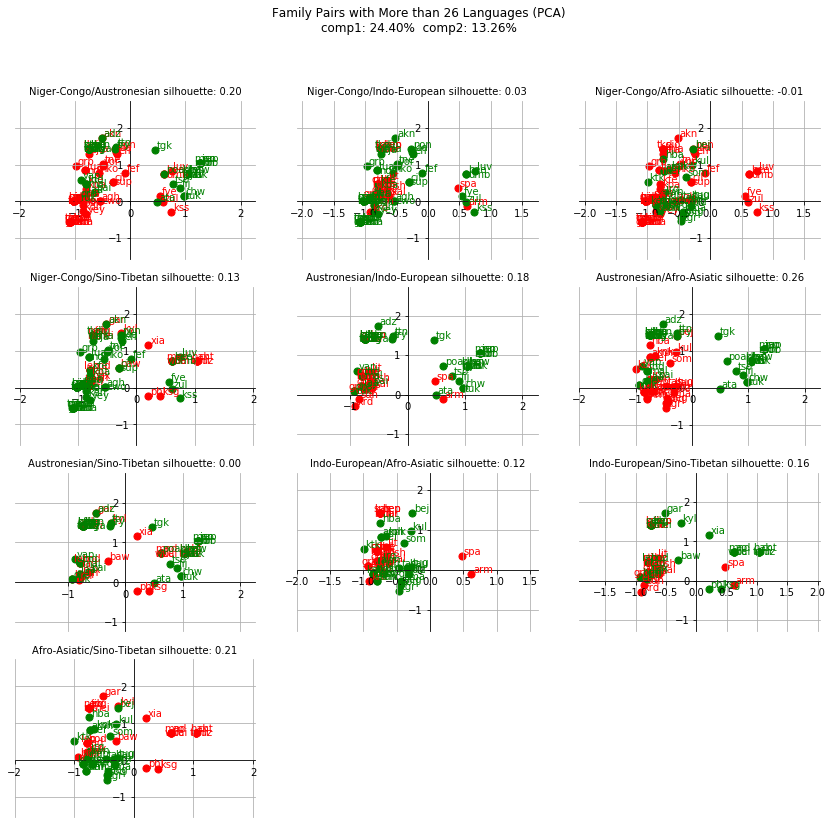

In [6]:
maxfams.plot_multifam()

### Same set, top families, MCA

In [29]:
maxfams.mode = 'mca'

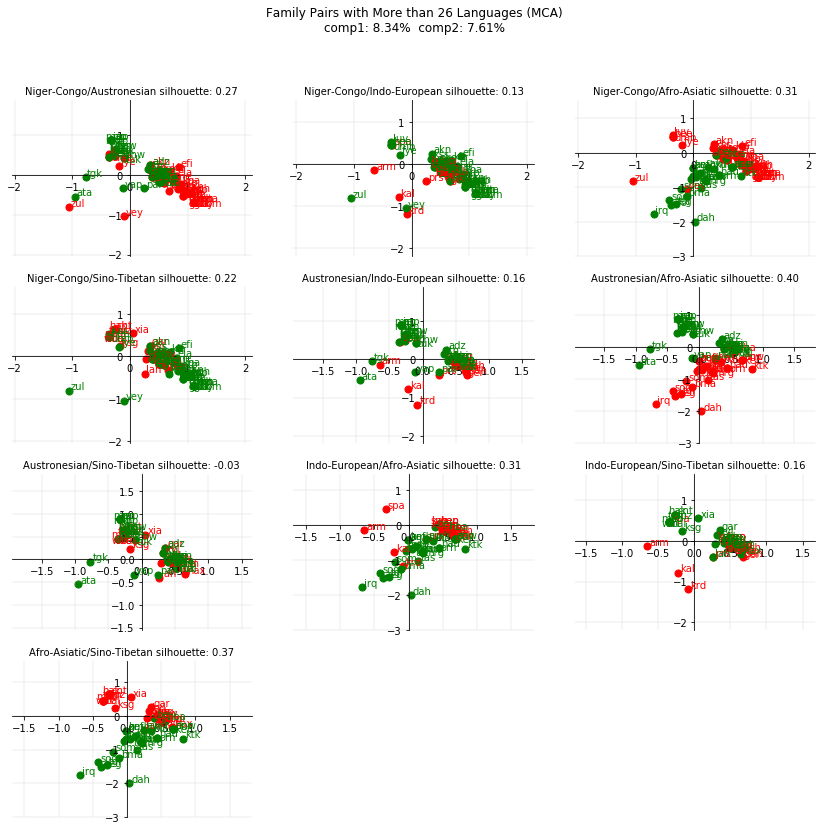

In [30]:
maxfams.plot_multifam()

## Finaly, the set with best genetic separation. 
### Remeber, these sets were picked at random, never selected for high genetic silhouette

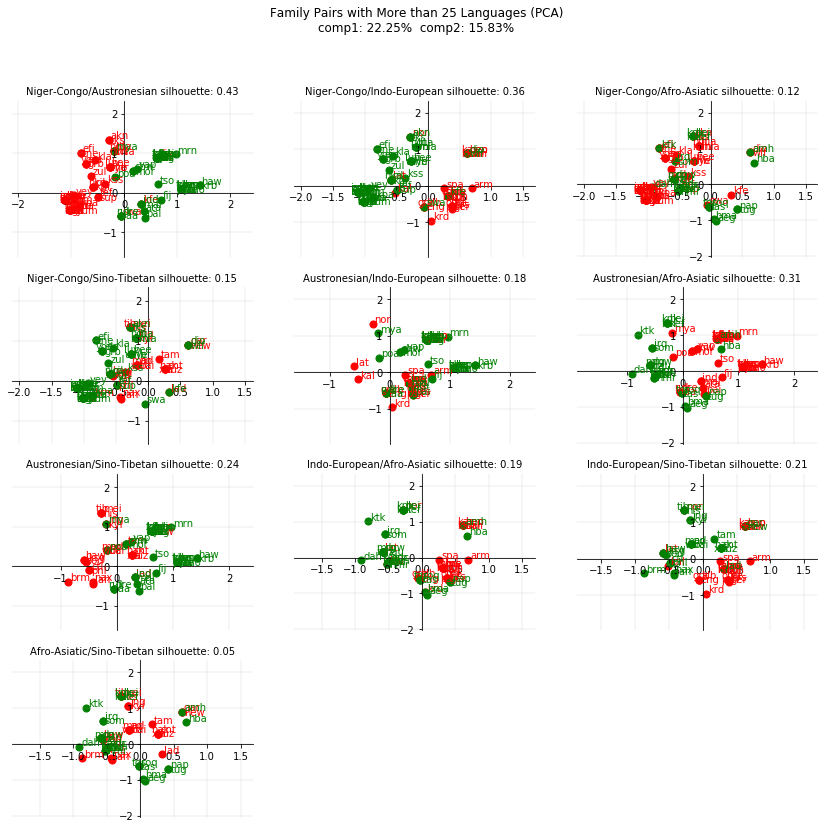

In [31]:
maxgen = groups[gstats['genetic silhouette'].argmax()]
maxgen.plot_multifam()

### MCA

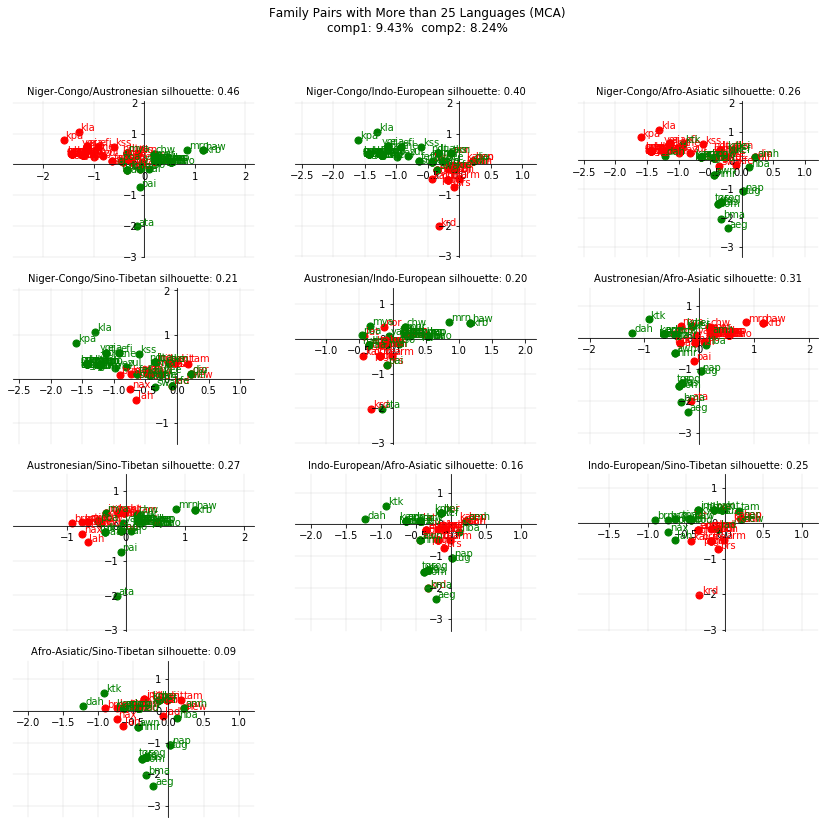

In [32]:
maxgen.mode = 'mca'
maxgen.plot_multifam()